### **Spacecraft_MRP_TD3** 
本项目将MRP替换四元数，对简单航天器进行重定向  
参考论文：Model-Free Attitude Control of Spacecraft Based on PID-Guide TD3 Algorithm

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
from TD3 import TD3
from spacecraft_env import SpacecraftEnv, plot_omega, plot_p, plot_Tr
import os

In [2]:
num_train = "1"   #保存的训练序号
save_path = "./saved_model_td3/taining_num_"+num_train    # 模型保存位置
os.makedirs(save_path, exist_ok=True)                       # exist_ok=True 表示如果对应目录已经存在，则不做任何事

#超参数设置
actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 600
hidden_dim = 250
gamma = 0.99
tau = 0.01  # 软更新参数，取值范围0~1，为1的时候表示把参数完全复制到目标网络中
buffer_size = 1000000
minimal_size = 1000
batch_size = 250
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_time = 200   #每个episode内的单位步长是1s,即计算200步
dt = 1
delay = 3

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)

env = SpacecraftEnv(env_time, dt)

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
agent = TD3(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device, delay)

### 引入预训练的模型，如果不引入，记得注释掉下方代码

In [ ]:
# num_train = "5"  
# load_path = "./saved_model_td3_1/taining_num_"+num_train
# agent.load_model(load_path)

### 训练模型并保存，如果不需要训练，可以跳过下面的代码，运行读取代码

In [3]:
return_list = rl_utils.train_off_policy_agent_td3(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)
agent.save_model(save_path)

Iteration 9: 100%|██████████| 60/60 [01:03<00:00,  1.06s/it, episode=600, return=11864.006]


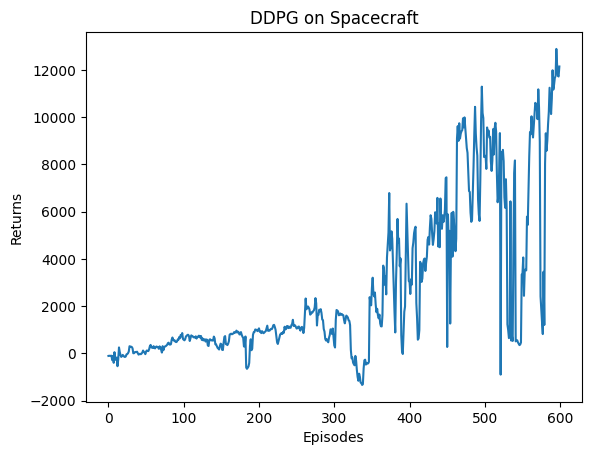

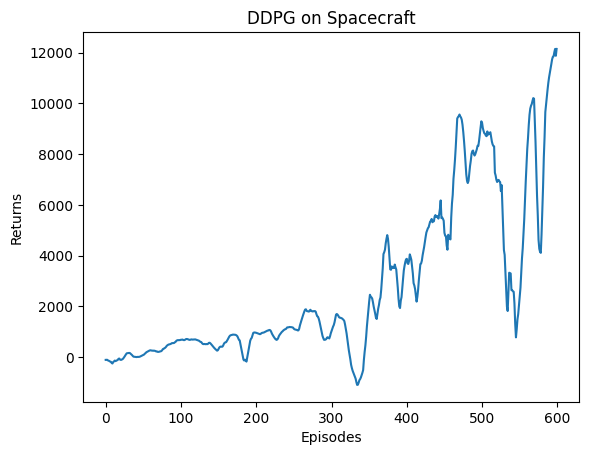

In [4]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on Spacecraft')
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on Spacecraft')
plt.show()

### 读取保存好的模型

In [5]:
num_train = "1"  #选择要读取哪个训练,取消注释
load_path = "./saved_model_td3/taining_num_"+num_train
agent.load_model(load_path)

### 用读取的Agent跑一次控制过程

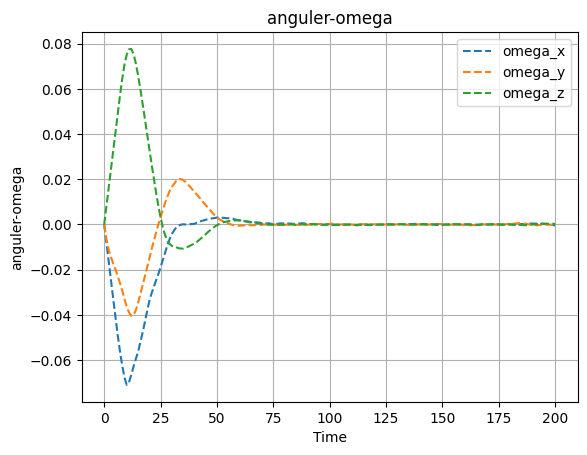

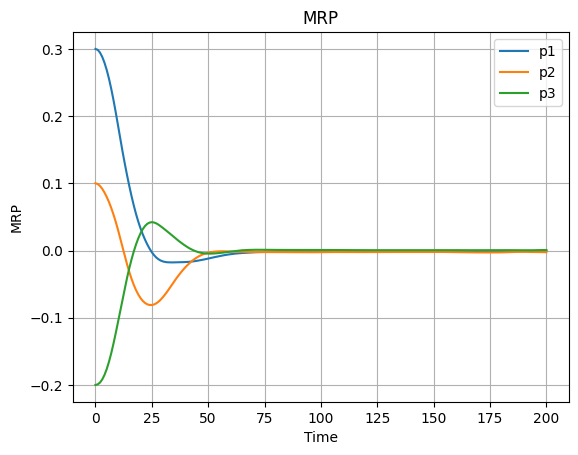

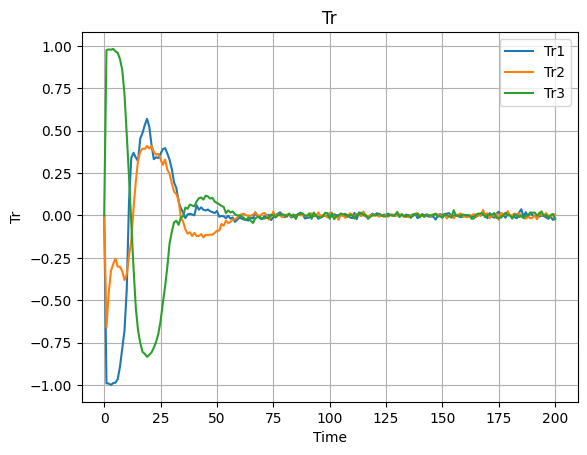

10829.535868029841
[-3.96648133e-04 -5.34529609e-05  1.86447985e-04 -3.63264289e-04
 -2.45834638e-03  8.03860046e-04]


In [6]:
episode_return = 0
env_test = SpacecraftEnv(200, 1)
state = env_test.reset()
done = False
while not done:
    action = agent.take_action(state)
    next_state, reward, done, _ = env_test.step(action)
    state = next_state
    episode_return += reward

plot_omega(env_test.t_sol, env_test.X_sol)
plot_p(env_test.t_sol, env_test.X_sol)
plot_Tr(env_test.t_sol, env_test.Tr_sol)
print(episode_return)
print(env_test.X_sol[:,-1])